# Self Attention Mechanism

In [ ]:
import numpy as np
def computeQKV(X,W_q,W_k,W_v):
    Q=X@W_q
    K=X@W_k
    V=X@W_v
    return Q,K,V

before using the self attention mechanism we must first create our Query, Key and Value matrices we do this by applying the respective weights to X which is the tokenized input

In [ ]:
from scipy.special import softmax

def self_attention(Q,K,V):
  d_k=K.shape[-1]
  score=Q@K.swapaxes(-2,-1)/np.sqrt(d_k)
  score=softmax(score,axis=-1)
  score=score@V
  return score

given that the formula for self attention is:

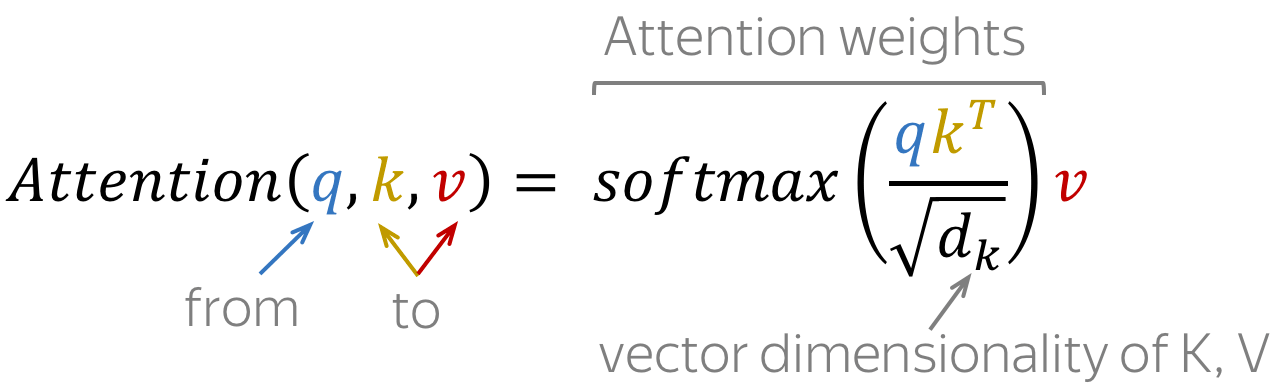

in the implementation above first we get d_k which is the model embedding size as Q,K, and V are either (seq_len,d_model) or (seq_len,num_heads,d_k) for multihead attention

then we matrix multiply the Q and K matrices with K transposed and divide it by the square root of the model embedding size (d_k). in this stage what we're essentially doing is creating an attention mask as given the query we matmul it with the transpose of T to get the similarity there for telling the model given this query here are how much attention should be given. we also use the sqrt of d_k so that we can scale Q@K.T preventing vanishing or exploding gradients. also we use .swapaxes(-2,-1) instead of .T since swapaxes can work for multihead wherein we have 3 dimensions whilst .T only works for singlehead attention as it only swaps the first two dimensions and ignores the third

we then apply softmax on axis=-1 which is the column making it so that we apply softmax by row and this makes it so that for every vector in the matrix the sum of the values in the vector is 1 essentially giving us a vector where the tokens are weighted

finally we matmul this to V to apply the attention mask to the value matrix and this will be the model's understanding.

# Multi-Head Attention

In [ ]:
import numpy as np
from typing import Tuple
from scipy.special import softmax

def compute_qkv(
    X: np.ndarray,
    W_q: np.ndarray,
    W_k: np.ndarray,
    W_v: np.ndarray
) -> Tuple[np.ndarray, np.ndarray, np.ndarray]:
    Q = X @ W_q
    K = X @ W_k
    V = X @ W_v
    return Q, K, V


to start we first create the Q,K and V matrices

In [ ]:
def self_attention(Q: np.ndarray, K: np.ndarray, V: np.ndarray) -> np.ndarray:
    d_k = K.shape[-1]
    scores = Q @ K.swapaxes(-2, -1) / np.sqrt(d_k)
    scores = softmax(scores, axis=-1)
    scores = scores @ V
    return scores


then we do the self attention mechanism

In [ ]:
def multi_head_attention(Q: np.ndarray, K: np.ndarray, V: np.ndarray, n_heads: int) -> np.ndarray:
  assert Q.shape[-1]%n_heads==0, "model embedding size must be divisibe by n_heads"
  d_head=Q.shape[-1]//n_heads
  d_model=Q.shape[-1]

  Q.reshape(Q.shape[0],n_heads,d_head)
  Q.tranpose(1,0,2)

  K.reshape(K.shape[0],n_heads,d_head)
  K.tranpose(1,0,2)

  V.reshape(V.shape[0],n_heads,d_head)
  V.tranpose(1,0,2)

  context=self_attention(Q,K,V)
  context=context.transpose(1,0,2)
  output=context.reshape(Q.shape[1],model)
  return output



given the formula:

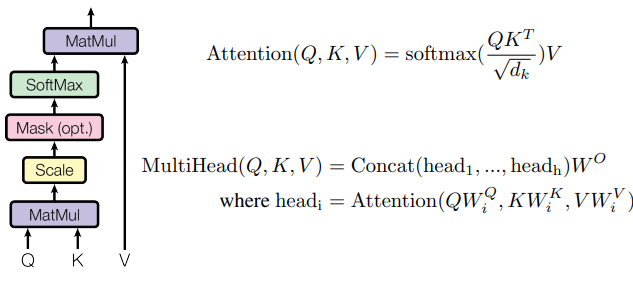

first we make sure that the model embedding size is divisible by the number of heads and then
after making sure that its possible we floor divide model embedding size by the number heads to get the dimension per head and we also get the model embedding size and store it as a variable for the concatenation of heads in the output.

then we reshape Q,K and V into (seq_len,n_heads,d_head) and transpose it so that the shape is (n_heads,seq_len,d_head) so that we stick to the format (seq_len, embedding dimension)

after that we call the self attention function to get the self attention score for all the heads. and then we put it back to (seq_len,n_heads,d_head) format through transpose again and use reshape to concatenate the self attention scores of all the heads.

# Masked Attention

masked attention is used in the decoder training so that the model doesn't see the data in front of it as when predicting it wouldn't know what's in front of it as it is still generating it/generating it is it's task.

essentially we mask the timesteps in front of the current one to prevent cheating.

In [ ]:
import numpy as np

from scipy.special import softmax

def compute_qkv(X: np.ndarray, W_q: np.ndarray, W_k: np.ndarray, W_v: np.ndarray):
    Q=X@W_q
    K=X@W_k
    V=X@W_v
    return Q,K,V

first before we do anything we have to calculate the Q,K and V matrices.

In [ ]:
def masked_attention(Q: np.ndarray, K: np.ndarray, V: np.ndarray, mask: np.ndarray) -> np.ndarray:
   d_k=K.shape[-1]
   seq_len=K.shape[-2]
   mask_shape=(seq_len,seq_len)

   score=Q@K.swapaxes(-2,-1)/np.sqrt(d_k)

   mask=np.triu(np.ones(mask_shape),k=1)

   score=softmax(score,axis=-1)
   score=score@V
   return score


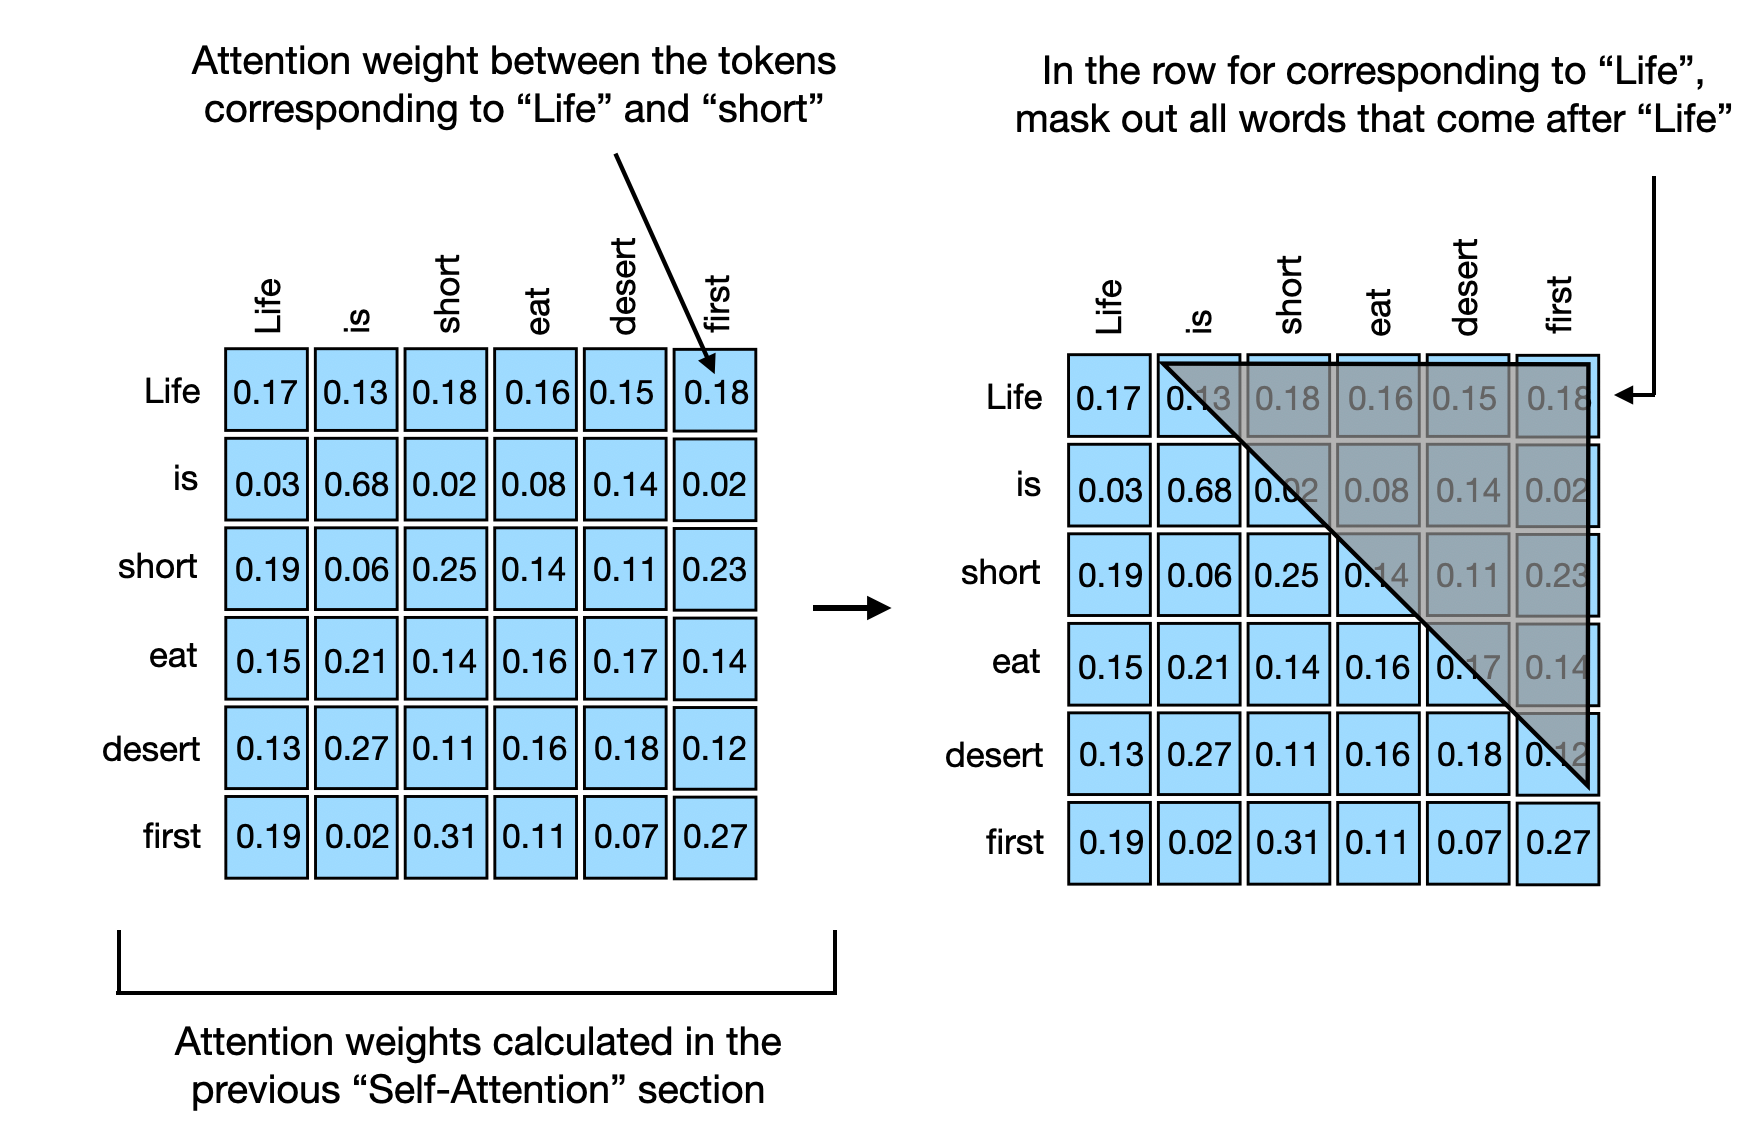

given the diagram above in our implementation we essentially need to mask the values above the diagonal.

firstly we get d_k or the model embedding size, then we get the sequence length using `K.shape[-2]` as the format is either (num_heads,seq_len,d_head) or (seq_len,d_model) so sequence length will always be the 2nd to the last dimension. lastly we create the mask shape which is just (seq len x seq len) and store it in a variable.

then we do the first part of the self attention formula by doing Q@K.T/sqrt(d_k)

after that we create a mask by doing `np.triu(np.ones(mask_shape),k=1)` what this essentially does is create a matrix where the upper triangular is full of ones but since we set the parameter k to 1 it ignores the diagonal and so we create a matrix of ones above the diagonal whilst everything from the diagonal to below it are zeros

we then apply the max using `score=np.where(mask==1,np.-inf,score)` wherein the cells/positions in the mask matrix where the values is 1 we turn it to np.-inf (negative infinity which is a very small value) in score thus making the values so small that it gets ignored.

we go back to normal implementation wherein we apply softmax rowise by to make our rows sum up to 1 and finally apply score or our attention mask to values by doing `score@V`

# Layer Normalization

Layer normalization is crucial in transformer models as it prevents vanishing and exploding gradients whilst making gradient descent easier by making the optimization function/optimization route as smooth as it can be/smoothing the landscape and allowing the model to train faster and deeper. also if the weights grow too large, Layer Norm "shrinks" the output back to a standard range. Layer Normalization ensures that the inputs fed into the _next_ block's Self-Attention mechanism remain in a reasonable range. Lastly By dividing by the standard deviation (normalizing the variance), Layer Norm essentially projects all token vectors onto a similar scale (a hyper-sphere). This forces the model to encode information in the **relationships** between features (the direction) rather than simply overpowering other tokens with massive values.

In [ ]:
import numpy as np

def layer_normalization(X: np.ndarray, gamma: np.ndarray, beta: np.ndarray, epsilon: float = 1e-5) -> np.ndarray:
    mean=X.mean(-1,keepdims=True)
    var=X.var(-1,keepdims=True)
    normalize=((X-mean)/np.sqrt(var+epsilon))*gamma+beta
    return normalize

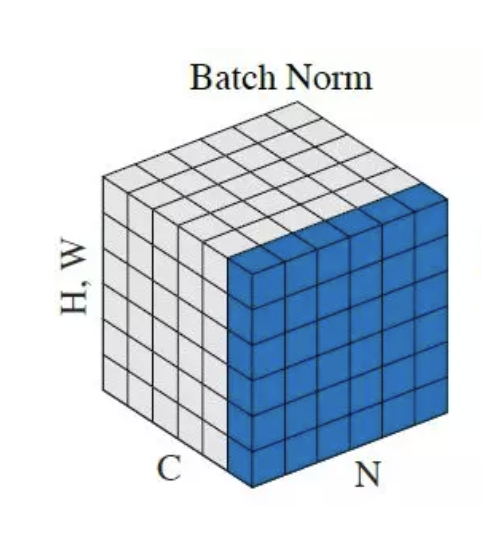

In the implementation above we first get the mean and the variance, on the parameters of both methods/functions we use (-1,keepdims=True). the -1 makes it so that we get the mean and variance on the model embedding dimension whilst we set keepdims to True as when we do this we essentially squish the matrix making it be 1 dimensional.

we then apply the normalization formula normalize=((X-mean)/np.sqrt(var+epsilon))*gamma+beta

# Positional Encoding

Positional encoding allows the model to see the position of each token in the sample is giving a transformer model the ability to immediately see the position of each token at the beginning.

In [ ]:
import numpy as np

def pos_encoding(seq_length: int, d_model: int):
    # 1. Initialize a matrix of shape (seq_length, d_model
    #    For inputs (2, 8), this creates a [2, 8] zeros matrix
    pe = np.zeros((seq_length, d_model))
    # 2. Create a column vector for positions: [[0], [1], [2]...]
    #    We use np.newaxis to turn shape (seq_length,) into (seq_length, 1)
    #    so it can broadcast against the row vector of frequencies.
    position = np.arange(seq_length)[:, np.newaxis]
    # 3. Calculate the division term (frequencies)
    #    This remains a 1D array of shape (d_model // 2,)
    div_term = 1/np.power(10000, np.arange(0, d_model, 2) / d_model)
    # 4. Fill the matrix
    #    pe[:, 0::2] means: "For ALL rows, fill even columns"
    #    position * div_term broadcasts to shape (seq_length, d_model//2)
    pe[:, 0::2] = np.sin(position * div_term)
    #    pe[:, 1::2] means: "For ALL rows, fill odd columns"
    pe[:, 1::2] = np.cos(position * div_term)
    return np.float16(pe)

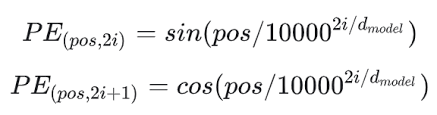

In the implementation we follow the standard formula, using sine for the even columns and cosine for the odd columns.

Firstly, we create the positional encoding matrix by creating a matrix with the same dimensions as the Q, K, and V matrices. So it is seq_len x d_model, and we create this with np.zeros to make this a matrix of all zeros.

Then for position, we create a vector with the range/length of seq_len and do [:, np.newaxis] to get the entire vector while adding a new dimension. This makes it (seq_len, 1), effectively turning it into a column vector so it can be broadcasted against the row vector of frequencies later.

Then we create the div_term through 1/np.power(10000, np.arange(0, d_model, 2) / d_model). We use np.arange to generate indices up to the model embedding dimension, but since we are stepping through pairs (sin/cos), we step by 2. This creates a curve of "frequencies" that gets slower as the dimension index increases.

Lastly, we apply the sin and cosine to the positions. We do pe[:, 0::2] to apply sine to all rows but only the even columns (0, 2, 4...), and pe[:, 1::2] to apply cosine to all rows but only the odd columns (1, 3, 5...).

We use sin and cosine because they create a unique "fingerprint" for every position. the model looks at the frequency of the waves. The lower dimensions (left side) wave very fast to help the model distinguish nearby tokens (like "which word is right next to me?"), while the higher dimensions (right side) wave very slowly to help tracking long-distance relationships across the sentence. By combining these fast and slow waves, the model can perfectly identify where any token is relative to any other token.